In [8]:
### Comparison of trends in GMST with different priors

In [116]:
### Prior on energy embalance 
### From Sherwood et al. (2025) https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2024AV001636
### We estimate the mean energy imbalance in the period 1970-2024, in 2023 it was reached 1.8 W/m² and the trend is estimated at 0.45 W/m² per decade
def ebm_trend(F=0.8, C=7e8):
    """
    Estimate GMST trend (°C/year) from forcing time series F(t)
    
    F: array-like, radiative forcing in W/m²
    C: heat capacity in J/m²/°C (default 7e8)
    """
    dT_dt = F / C  # °C/s
    return dT_dt * 3.154e7  # °C/year

ebm_trend()

0.036045714285714285

In [117]:
### Imports
import pandas as pd
import xarray as xr
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [118]:
### Data
path = "/home/jmindlin/BF_codes/data/DCENT_GMST_statistics.txt"

# Find the header line ("Year,GMST (°C),...")
with open(path, "r", encoding="utf-8") as f:
    lines = f.readlines()

start = next(i for i, line in enumerate(lines) if line.strip().startswith("Year,"))


# Read CSV from that header line onward; allow commas with spaces
df = pd.read_csv(
    path,
    skiprows=start,               # start at the header line
    engine="python",
    sep=r"\s*,\s*",               # split on commas, ignoring surrounding spaces
    comment=None
)

# Clean column names to something easy to use
rename_map = {
    "Year": "year",
    "GMST (°C)": "gmst",
    "1 s.d. (°C)": "gmst_sd",
    "GMST non infilled (°C)": "gmst_noninf",
    "1 s.d. (°C; non  infilled)": "gmst_noninf_sd",
}
# in case of double spaces etc., normalize header keys first
df.columns = [re.sub(r"\s+", " ", c).strip() for c in df.columns]
rename_map_norm = {re.sub(r"\s+", " ", k).strip(): v for k, v in rename_map.items()}
df = df.rename(columns=rename_map_norm)

# Ensure numeric dtypes
for c in ["year", "gmst", "gmst_sd", "gmst_noninf", "gmst_noninf_sd"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Convert to xarray
ds = xr.Dataset(
    {
        "GMST": (["year"], df["gmst"].values),
        "GMST_sd": (["year"], df["gmst_sd"].values),
        "GMST_non_infilled": (["year"], df["gmst_noninf"].values),
        "GMST_non_infilled_sd": (["year"], df["gmst_noninf_sd"].values),
    },
    coords={"year": df["year"].values.astype(int)},
)
ds_full = ds.copy()
ds = ds - ds.sel(year=slice('1951','1980')).mean(dim='year')


In [119]:

def compute_marginal_likelihood_gaussian_prior(y, t, mu0, tau2):
    """
    Compute log marginal likelihood for y ~ N(beta * x, sigma^2 I)
    with Gaussian prior on beta ~ N(mu0, tau2)
    """
    # Center time
    x = t - np.mean(t)
    n = len(y)

    # OLS estimate of beta
    S = np.sum(x**2)
    beta_hat = np.sum(x * y) / S
    y_hat = beta_hat * x
    RSS = np.sum((y - y_hat)**2)

    # Estimate sigma^2 from residuals
    sigma2 = RSS / n

    # Log marginal likelihood
    denom_term = 1 + tau2 * S / sigma2
    penalty = (tau2 / denom_term) * (beta_hat - mu0)**2 * S
    logml = (
        -0.5 * n * np.log(2 * np.pi * sigma2)
        -0.5 * np.log(denom_term)
        -0.5 / sigma2 * (RSS + penalty)
    )
    return logml

# Prepare data
t = ds.year.values
y = ds['GMST'].sel(year=slice(1979, 2024)).values
t = t[:len(y)]  # Ensure matching length

# Prior on trend 
mu0 = 0.036       # °C/decade
tau2 = 0.01**2      # Prior std dev 0.05

# Compute marginal likelihood
log_marginal_likelihood = compute_marginal_likelihood_gaussian_prior(y, t, mu0, tau2)
print(f"Log marginal likelihood (Gaussian prior on β): {log_marginal_likelihood:.2f}")


Log marginal likelihood (Gaussian prior on β): -40.90


In [120]:
def log_marginal_likelihood_beta_0(y, sigma):
    """
    Compute the log marginal likelihood under H0: beta = 0
    assuming Gaussian likelihood N(0, sigma^2) for each observation.
    
    Parameters:
        y : array-like
            The data (e.g., anomalies).
        sigma : float
            Known standard deviation of the noise.
    
    Returns:
        float : log marginal likelihood
    """
    return np.sum(norm.logpdf(y, loc=0, scale=sigma))

# Example usage
sigma_hat = ds['GMST'].sel(year=slice(1951, 1980)).std().item()  # Estimate sigma from pre-1980 data
log_ml_beta_0 = log_marginal_likelihood_beta_0(y, sigma_hat)
print("Log marginal likelihood under H0 (beta=0):", log_ml_beta_0)

Log marginal likelihood under H0 (beta=0): -604.3373574878648


In [121]:
BF = np.exp(log_marginal_likelihood - log_ml_beta_0)

In [122]:
print("Bayes Factor (Gaussian prior on β vs β=0):", BF)

Bayes Factor (Gaussian prior on β vs β=0): 5.009685452779536e+244


### Uniform prior

In [123]:
n=len(y)
# === Design matrix for intercept and linear trend ===
X = np.column_stack([np.ones(n), t - 1979])

# === Fit OLS model to estimate intercept and sigma ===
beta_hat, residuals, _, _ = np.linalg.lstsq(X, y, rcond=None)
y_hat = X @ beta_hat
sigma_hat = np.std(y - y_hat)

# === Define grid over beta values for integration ===
beta_grid = np.linspace(0.001, 0.05, 500)
prior_width = beta_grid[-1] - beta_grid[0]

# === Compute log-likelihoods for each beta in the grid ===
log_likelihoods = []
intercept = beta_hat[0]  # fixed from OLS
for beta in beta_grid:
    y_pred = intercept + beta * (t - 1979)
    ll = norm.logpdf(y, loc=y_pred, scale=sigma_hat).sum()
    log_likelihoods.append(ll)

log_likelihoods = np.array(log_likelihoods)

# === Convert to likelihoods safely for numerical stability ===
likelihoods = np.exp(log_likelihoods - np.max(log_likelihoods))

# === Compute marginal likelihood: average under uniform prior ===
marginal_likelihood_uniform = likelihoods.mean()
log_marginal_likelihood_uniform = np.log(marginal_likelihood_uniform) + np.max(log_likelihoods)

print(f"Log marginal likelihood (uniform prior on β): {log_marginal_likelihood_uniform:.2f}")



Log marginal likelihood (uniform prior on β): 34.32


In [111]:
BF = np.exp(log_marginal_likelihood_uniform - log_ml_beta_0)

In [112]:
print("Bayes Factor (Uniform prior on β vs β=0):", BF)

Bayes Factor (Uniform prior on β vs β=0): 2.3239439243931634e+277


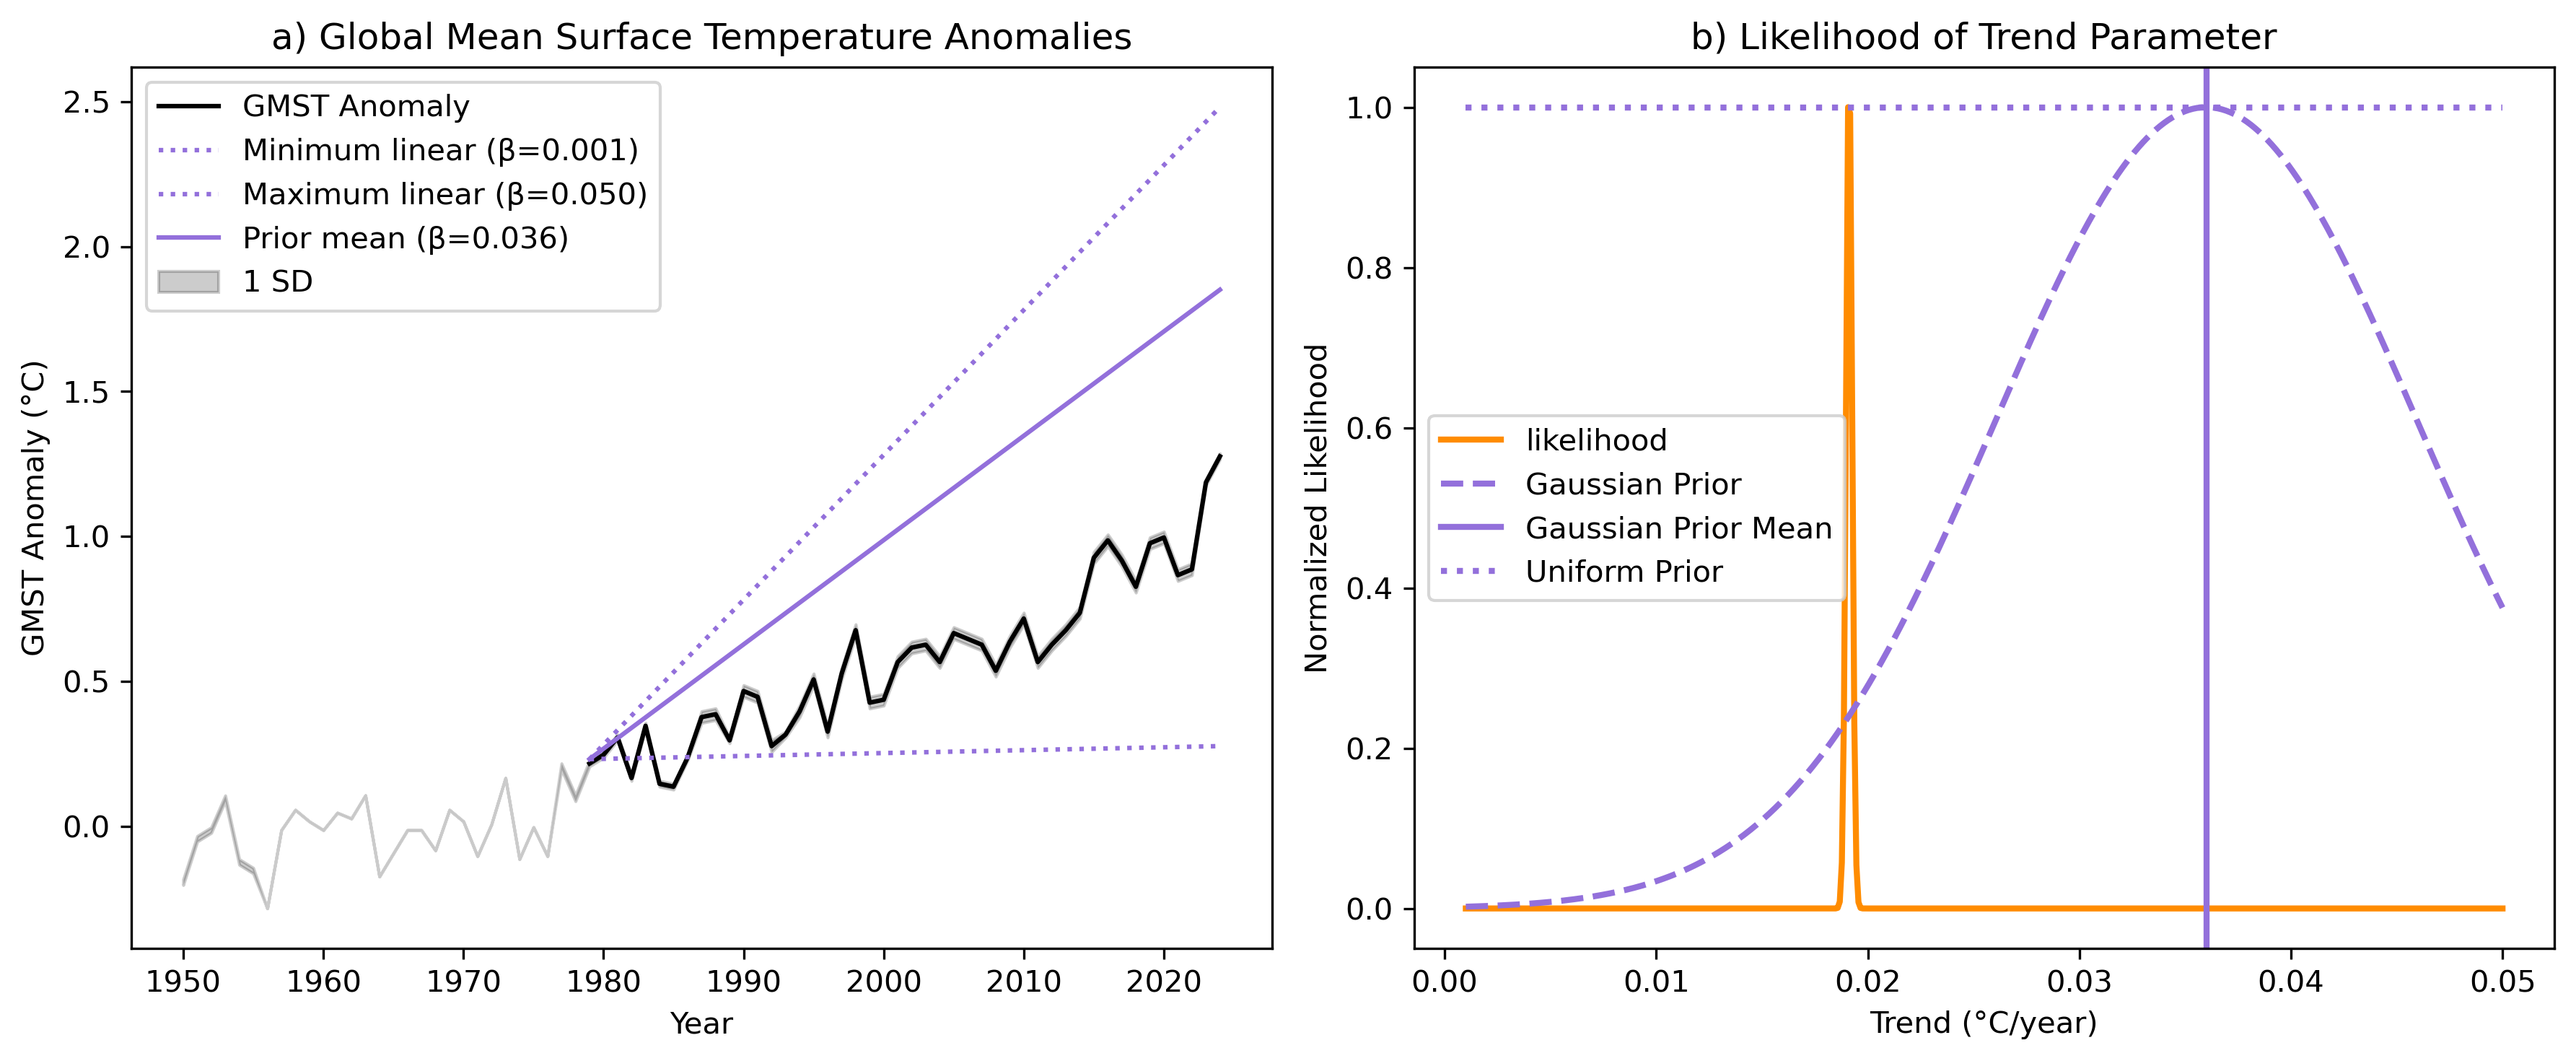

In [128]:
### Make a figure with two panels, GMST and the likelihoods
fig, axs = plt.subplots(1, 2, figsize=(12, 5),dpi=300)
# Panel 1: GMST time series
axs[0].plot(ds.sel(year=slice('1979','2025')).year, ds['GMST'].sel(year=slice('1979','2025')), label='GMST Anomaly', color='k')
### Add the minimum and maximum linear fits in the beta grid
beta_min = beta_grid[0]
beta_max = beta_grid[-1]
intercept = ds['GMST'].sel(year=slice('1979','1980')).mean().item()
axs[0].plot(ds.sel(year=slice('1979','2025')).year, intercept + beta_min * (ds.sel(year=slice('1979','2025')).year - 1979), label=f'Minimum linear (β={beta_min:.3f})', color='MediumPurple', linestyle=':')
axs[0].plot(ds.sel(year=slice('1979','2025')).year, intercept + beta_max * (ds.sel(year=slice('1979','2025')).year - 1979), label=f'Maximum linear (β={beta_max:.3f})', color='MediumPurple', linestyle=':')
### Add a linear line for what was my prior, 0.08 °C/decade
axs[0].plot(ds.sel(year=slice('1979','2025')).year, intercept + mu0 * (ds.sel(year=slice('1979','2025')).year - 1979), label=f'Prior mean (β={mu0:.3f})', color='MediumPurple', linestyle='-')
axs[0].fill_between(ds.sel(year=slice('1950','2025')).year, ds['GMST'].sel(year=slice('1950','2025')) - ds['GMST_sd'].sel(year=slice('1950','2025')), ds['GMST'].sel(year=slice('1950','2025')) + ds['GMST_sd'].sel(year=slice('1950','2025')), color='k', alpha=0.2, label='1 SD')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('GMST Anomaly (°C)')
axs[0].set_title('a) Global Mean Surface Temperature Anomalies')
axs[0].legend()
# Panel 2: Prior
axs[1].plot(beta_grid, likelihoods, label='likelihood', color='DarkOrange',linewidth=2)
axs[1].set_xlabel('Trend (°C/year)')
axs[1].set_ylabel('Normalized Likelihood')

### Gaussian prior 
prior_gaussian = norm.pdf(beta_grid, loc=mu0, scale=np.sqrt(tau2))
axs[1].plot(beta_grid, prior_gaussian/prior_gaussian.max(), label='Gaussian Prior', color='MediumPurple', linestyle='--',linewidth=2)

axs[1].axvline(mu0, color='MediumPurple', linestyle='-', label='Gaussian Prior Mean',linewidth=2)
## Uniform prior
prior_uniform = np.ones_like(beta_grid) / prior_width
axs[1].plot(beta_grid, prior_uniform /prior_uniform.max(), label='Uniform Prior', color='MediumPurple', linestyle=':',linewidth=2)
axs[1].set_title('b) Likelihood of Trend Parameter')
axs[1].legend()
plt.tight_layout()
plt.show()


In [ ]:
### MediumPurpl color list with names
MediumPurpl_colors = [
    "LavenderBlush",
    "Thistle",
    "Plum",
    "Violet",
    "Orchid",
    "MediumOrchid",
    "DarkOrchid",
    "DarkViolet",
    "BlueViolet",
    "MediumPurpl",
    "Indigo",
    "DarkMagenta",
    "MediumMediumPurpl",
    "RebeccaMediumPurpl",
    "SlateBlue",
    "MediumSlateBlue",
    "DarkSlateBlue",
    "MediumAquamarine"
]